[*********************100%***********************]  27 of 28 completed

1 Failed download:
['GFL']: ReadTimeout(ReadTimeoutError("HTTPSConnectionPool(host='query2.finance.yahoo.com', port=443): Read timed out. (read timeout=10)"))
[*********************100%***********************]  27 of 28 completed

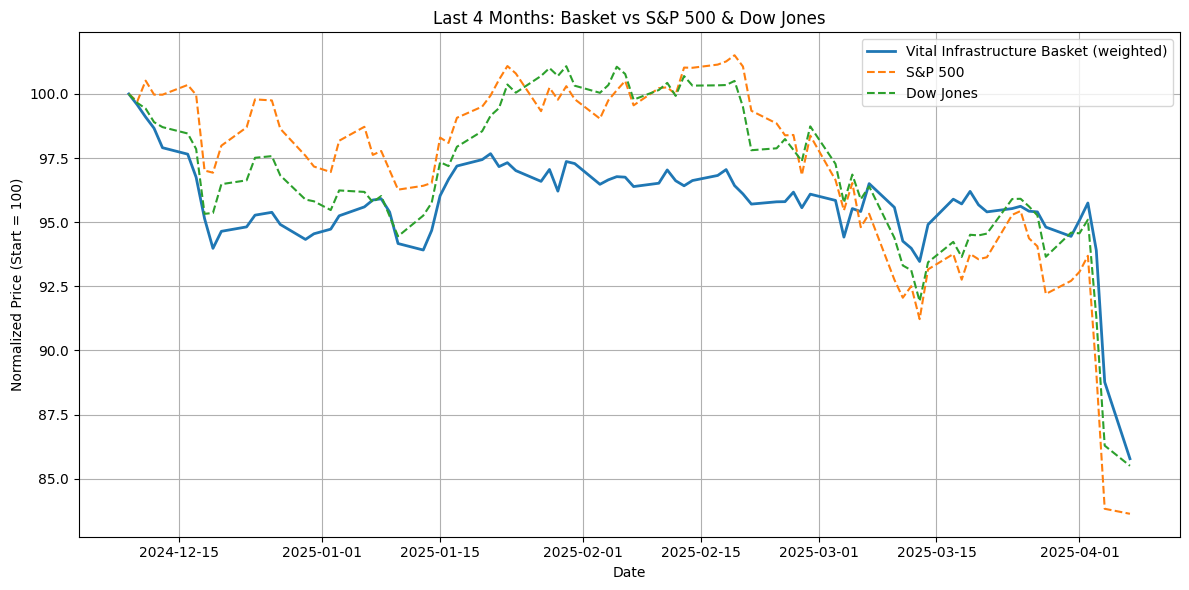

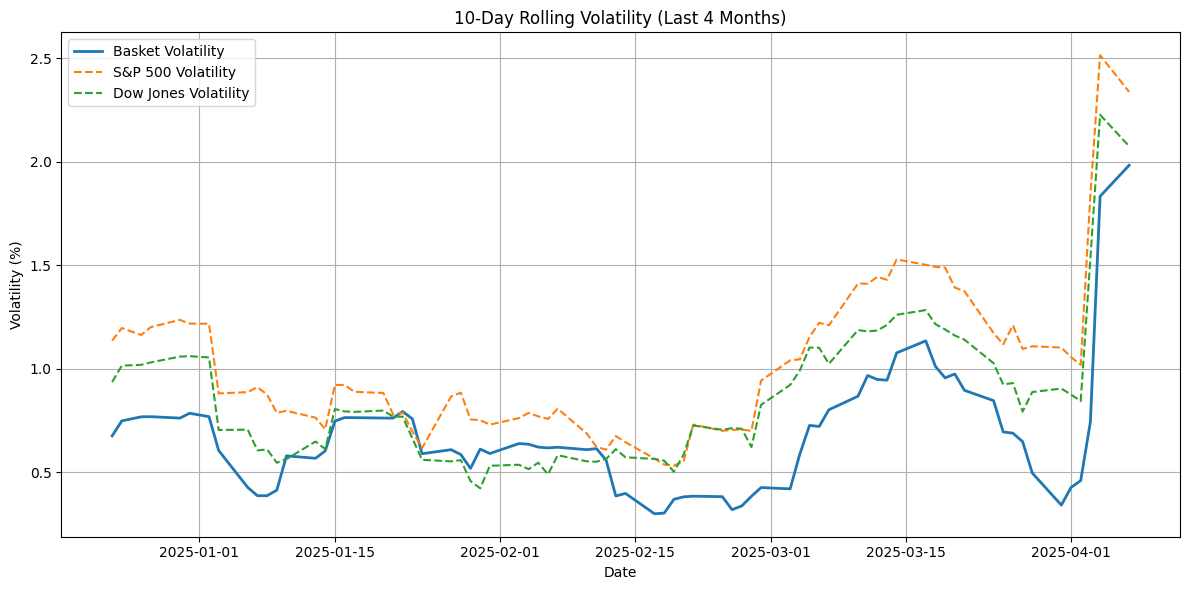

In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# === Volatility-based weights ===
weights = {
    "AUTO.OL": 0.019094, "BKW.SW": 0.050846, "BMI": 0.033615, "CGNX": 0.028368, "CLH": 0.038201,
    "CWST": 0.047824, "CWY.AX": 0.038031, "ECL": 0.054767, "ENEL.MI": 0.063910, "ENR.DE": 0.023263,
    "FSLR": 0.019741, "GF.SW": 0.035485, "GFL": 0.038149, "GXO": 0.028886, "IBE.MC": 0.066922,
    "KGX.DE": 0.029591, "MANH": 0.032971, "NEE": 0.040971, "ORSTED.CO": 0.028671, "SYM": 0.011842,
    "TOM.OL": 0.019474, "VIE.PA": 0.055726, "VLTO": 0.053097, "WM": 0.057568, "XYL": 0.048435, "ZBRA": 0.034552
}
weights = pd.Series(weights)

# Time range: last 4 months
end_date = pd.Timestamp.today()
start_date = end_date - pd.DateOffset(months=4)

# Benchmark tickers
benchmark_tickers = ["^GSPC", "^DJI"]
basket_tickers = list(weights.index)
all_tickers = basket_tickers + benchmark_tickers

# Download data
data = yf.download(all_tickers, start=start_date, end=end_date, auto_adjust=True)
if isinstance(data.columns, pd.MultiIndex):
    data = data["Close"]

# Clean and filter data
data = data.interpolate(method="linear")
data = data.dropna(thresh=int(0.7 * len(data.columns)))
data = data.loc[:, data.isna().mean() < 0.3]

# Use available tickers for weighting
valid_weights = weights[weights.index.isin(data.columns)]
valid_weights = valid_weights / valid_weights.sum()
basket_data = data[valid_weights.index]

# Normalize and calculate basket
normalized_basket = basket_data.divide(basket_data.iloc[0]) * 100
basket_index = normalized_basket.multiply(valid_weights, axis=1).sum(axis=1)

# Normalize benchmarks
normalized_sp500 = data["^GSPC"] / data["^GSPC"].iloc[0] * 100 if "^GSPC" in data else None
normalized_dow = data["^DJI"] / data["^DJI"].iloc[0] * 100 if "^DJI" in data else None

# Plot
plt.figure(figsize=(12, 6))
plt.plot(basket_index, label="Vital Infrastructure Basket (weighted)", linewidth=2)
if normalized_sp500 is not None:
    plt.plot(normalized_sp500, label="S&P 500", linestyle="--", linewidth=1.5)
if normalized_dow is not None:
    plt.plot(normalized_dow, label="Dow Jones", linestyle="--", linewidth=1.5)

plt.title("Last 4 Months: Basket vs S&P 500 & Dow Jones")
plt.xlabel("Date")
plt.ylabel("Normalized Price (Start = 100)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# === Daily returns ===
basket_returns = basket_index.pct_change()
sp500_returns = data["^GSPC"].pct_change() if "^GSPC" in data else None
dow_returns = data["^DJI"].pct_change() if "^DJI" in data else None

# === Rolling volatility (10-day window, in %)
basket_vol = basket_returns.rolling(window=10).std() * 100
sp500_vol = sp500_returns.rolling(window=10).std() * 100 if sp500_returns is not None else None
dow_vol = dow_returns.rolling(window=10).std() * 100 if dow_returns is not None else None

# === Plot rolling volatility ===
plt.figure(figsize=(12, 6))
plt.plot(basket_vol, label="Basket Volatility", linewidth=2)
if sp500_vol is not None:
    plt.plot(sp500_vol, label="S&P 500 Volatility", linestyle="--", linewidth=1.5)
if dow_vol is not None:
    plt.plot(dow_vol, label="Dow Jones Volatility", linestyle="--", linewidth=1.5)

plt.title("10-Day Rolling Volatility (Last 4 Months)")
plt.xlabel("Date")
plt.ylabel("Volatility (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [2]:
%pip install statsmodels

  Using cached patsy-1.0.1-py2.py3-none-any.whl.metadata (3.3 kB)
   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.8 MB ? eta -:--:--
   ----- ---------------------------------- 1.3/9.8 MB 3.8 MB/s eta 0:00:03
   -------- ------------------------------- 2.1/9.8 MB 4.1 MB/s eta 0:00:02
   ------------ --------------------------- 3.1/9.8 MB 4.3 MB/s eta 0:00:02
   ---------------- ----------------------- 3.9/9.8 MB 4.1 MB/s eta 0:00:02
   -------------------- ------------------- 5.0/9.8 MB 4.3 MB/s eta 0:00:02
   ----------------------- ---------------- 5.8/9.8 MB 4.3 MB/s eta 0:00:01
   -------------------------- ------------- 6.6/9.8 MB 4.2 MB/s eta 0:00:01
   --------------------------------- ------ 8.1/9.8 MB 4.5 MB/s eta 0:00:01
   ---------------------------------------  9.7/9.8 MB 4.8 MB/s eta 0:00:01
   ---------------------------------------- 9.8/9.8 MB 4.5 MB/s eta 0:00:00
Using cached patsy-1.0.1-py2.py3-non

In [3]:
import numpy as np
import statsmodels.api as sm

# Align and drop missing
comparison_df = pd.DataFrame({
    "Basket": basket_index.pct_change(),
    "S&P 500": data["^GSPC"].pct_change() if "^GSPC" in data else np.nan,
    "Dow Jones": data["^DJI"].pct_change() if "^DJI" in data else np.nan
}).dropna()

results = {}

# Loop through benchmarks
for benchmark in ["S&P 500", "Dow Jones"]:
    if benchmark not in comparison_df.columns:
        continue

    x = comparison_df[benchmark]
    y = comparison_df["Basket"]
    x_with_const = sm.add_constant(x)  # add alpha term

    model = sm.OLS(y, x_with_const).fit()
    alpha = model.params["const"]
    beta = model.params[benchmark]
    corr = y.corr(x)

    results[benchmark] = {
        "Alpha (daily)": round(alpha, 6),
        "Beta": round(beta, 3),
        "Correlation": round(corr, 3)
    }

# Display results
print("\n📈 Alpha, Beta, Correlation vs Basket:")
for benchmark, vals in results.items():
    print(f"\n{benchmark}:")
    for metric, val in vals.items():
        print(f"  {metric}: {val}")



📈 Alpha, Beta, Correlation vs Basket:

S&P 500:
  Alpha (daily): -0.000648
  Beta: 0.557
  Correlation: 0.736

Dow Jones:
  Alpha (daily): -0.000551
  Beta: 0.685
  Correlation: 0.786
